## Strategy

> To trade support and resistance levels as well as some well known chart patterns

### *Signals*

> Bounce on resistance / pass support for 2 days = sell

> Bounce on support / pass resistance for 2 days = buy

> Head and shoulders trade


In [5]:
# imports 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('fivethirtyeight')
import math
import seaborn as sns
from datetime import datetime
from scipy.signal import argrelextrema


In [91]:
# data import 
df = pd.read_excel('Time Series Data.xlsx', index_col = 'Day')
df = df.iloc[0:1000]


In [92]:
# Identifying turning points

def get_max_min(prices, smoothing, window_range):
    
    smooth_prices = prices.rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []
    
    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range].idxmin())  
            
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]
    p = prices.reset_index()   
    max_min['day_num'] = p[p['Day'].isin(max_min.date)].index.values
    max_min = max_min.set_index('day_num')
    
    return max_min, maxima, minima

smoothing = 3
window = 10

[minmax, maxima, minima] = get_max_min(df['Series 1'], smoothing, window)
minmax.head()

,date,Series 1
day_num,,
11,11,100.482035
17,17,97.136867
23,23,89.739548
25,25,90.706678
40,40,97.654098


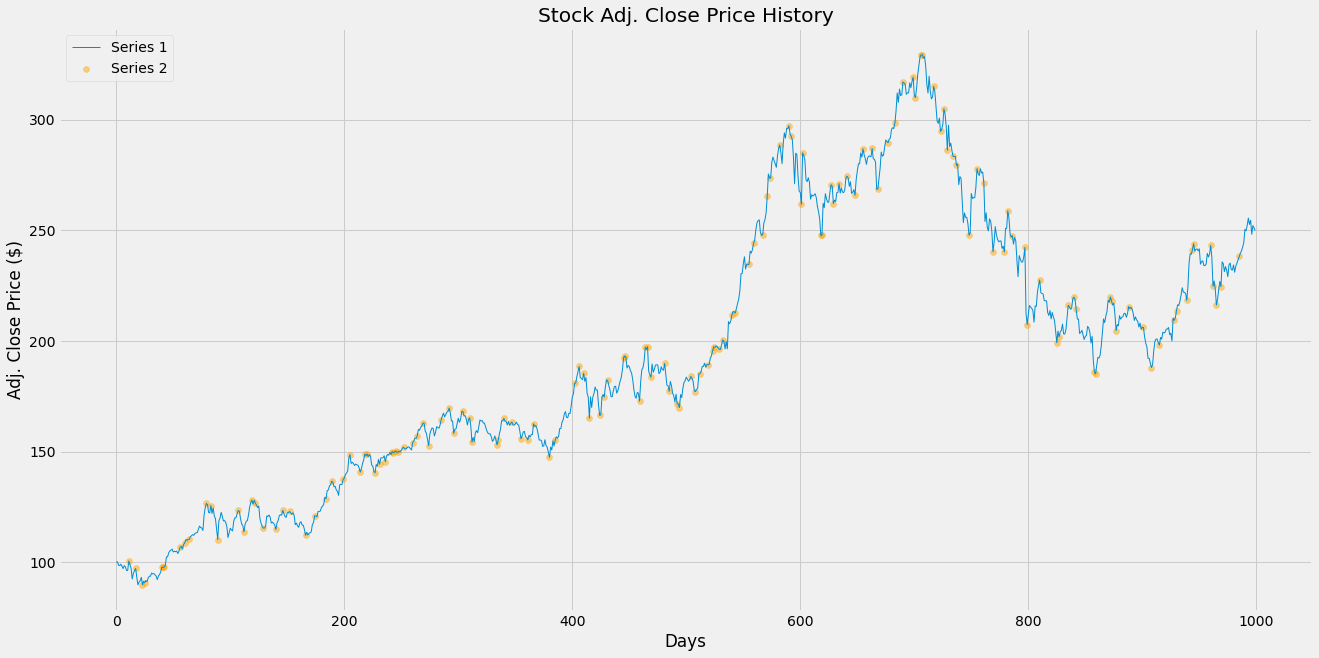

In [93]:
# plotting turning points
#Visualise the data

plt.figure(figsize=(20, 10))
plt.plot(df.reset_index()['Series 1'], linewidth = 1)
plt.scatter(minmax.index, minmax['Series 1'].values, color='orange', alpha=.5)
plt.title('Stock Adj. Close Price History')
plt.xlabel('Days')
plt.ylabel('Adj. Close Price ($)')
plt.legend(df, loc='upper left')
plt.show()


## Strategy 2

#### Identifying levels of support and resistance

In [97]:
# import necessary libraries
import matplotlib.dates as mpl_dates

# df selected for testing purposes
df = df['Series 2']

In [98]:
#method 1: fractal candlestick pattern
# determine bullish fractal 

def is_support(df,i):  
    
    cond1 = df[i] < df[i-1]   
    cond2 = df[i] < df[i+1]   
    cond3 = df[i+1] < df[i+2]   
    cond4 = df[i-1] < df[i-2]  
    return (cond1 and cond2 and cond3 and cond4) 

# determine bearish fractal
def is_resistance(df,i):  
    
    cond1 = df[i] > df[i-1]   
    cond2 = df[i] > df[i+1]   
    cond3 = df[i+1] > df[i+2]   
    cond4 = df[i-1] > df[i-2]  
    return (cond1 and cond2 and cond3 and cond4)

# to make sure the new level area does not exist already
def is_far_from_level(value, levels, df):    
    ave =  np.mean(np.nanmean(maxima)-np.nanmean(minima))    
    return np.sum([abs(value-level)<ave for _,level in levels])==0

# a list to store resistance and support levels
levels = []

for i in range(2, df.shape[0] - 2):  
    
    if is_support(df, i):    
        low = df[i]    
        if is_far_from_level(low, levels, df):      
            levels.append((i, low))  
    elif is_resistance(df, i):    
        high = df[i]    
        if is_far_from_level(high, levels, df):      
            levels.append((i, high))


In [99]:
# for visualization
def plot_all(levels, df):    
    fig, ax = plt.subplots(figsize=(16, 9))   
    ax.plot(df, linewidth=2, alpha=0.8)        
    
    for level in levels:        
        plt.hlines(level[1], xmin = df.reset_index()['Day'][level[0]], xmax = 
            max(df.reset_index()['Day']), colors='red', linestyle='--', linewidth=1)    
    plt.show()


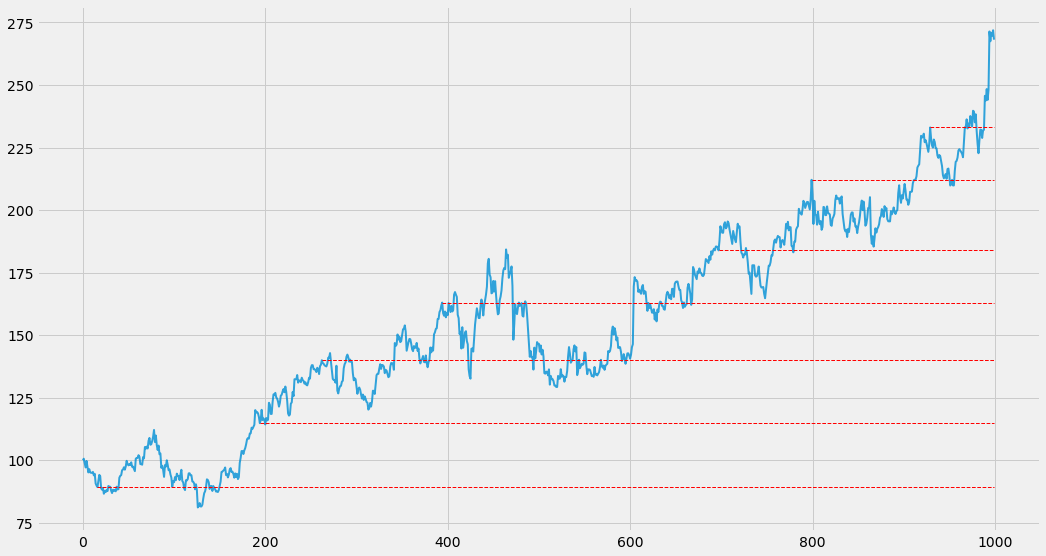

In [100]:
# testing for Series 1
plot_all(levels, df)


In [38]:
#method 2: window shifting method
#using the same symbol as the first example above
symbol = 'COST'
df = get_stock_price(symbol)
pivots = []
max_list = []
min_list = []
for i in range(5, len(df)-5):
  # taking a window of 9 candles
  high_range = df['High'][i-5:i+4]
  current_max = high_range.max()
  # if we find a new maximum value, empty the max_list 
  if current_max not in max_list:
    max_list = []
  max_list.append(current_max)
  # if the maximum value remains the same after shifting 5 times
  if len(max_list)==5 and is_far_from_level(current_max,pivots,df):
      pivots.append((high_range.idxmax(), current_max))
    
  low_range = df['Low'][i-5:i+5]
  current_min = low_range.min()
  if current_min not in min_list:
    min_list = []
  min_list.append(current_min)
  if len(min_list)==5 and is_far_from_level(current_min,pivots,df):
    pivots.append((low_range.idxmin(), current_min))
plot_all(pivots, df)

NameError: name 'get_stock_price' is not defined

In [ ]:
#method 2: window shifting method
#using the same symbol as the first example above

pivots = []
max_list = []
min_list = []

for i in range(5, len(df)-5):
    
    # taking a window of 9 candles
    high_range = df[i-5:i+4]
    current_max = high_range.max()
    
    # if we find a new maximum value, empty the max_list 
    if current_max not in max_list:
        max_list = []
        max_list.append(current_max)
        
    # if the maximum value remains the same after shifting 5 times
    if len(max_list)==5 and is_far_from_level(current_max,pivots,df):
        pivots.append((high_range.idxmax(), current_max))
    
  low_range = df['Low'][i-5:i+5]
  current_min = low_range.min()
  if current_min not in min_list:
    min_list = []
  min_list.append(current_min)
  if len(min_list)==5 and is_far_from_level(current_min,pivots,df):
    pivots.append((low_range.idxmin(), current_min))
plot_all(pivots, df)